In [22]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [23]:
def change_state(x, x1, x2):

    if np.array_equal(x, x1):
        return x2.copy()
    
    elif np.array_equal(x, x2):
        return x1.copy()

def get_valence_signal(x, x1, x2, R1, R2):

    if np.array_equal(x, x1):
        return R1
    elif np.array_equal(x, x2):
        return R2
    
def compute_p_change(y):

    if y<0.05:
        return 0.05
    else:
        return y
    
class BCM:
    
    def __init__(self, block_threshold, tau_w, tau_theta, theta0):

        self.tau_w = tau_w
        self.tau_theta = tau_theta

        self.theta = theta0

        self.block_threshold = block_threshold
    
    def get_weights_update(self, x, y, R):

        theta_dot = - 1./self.tau_theta * (self.theta - y**2)

        w_dot = 1./self.tau_w * -R * x * y * (y - self.theta)

        if not self.block_threshold:
            self.theta = self.theta + theta_dot
        
        return w_dot

In [24]:
# Possible states
x1, x2 = np.array([1., 0.]), np.array([0., 1.])

# Rs
Rm = -1 
Rp = 1.5

# Other parameters
tau_w = 100
tau_theta = 50

# Number of steps
number_of_mice = 10
steps_phase1 = 10000

# Data storage
starting_points_data = []

In [25]:
# Sham Mice
starting_points = [(0.2, 0.3), (0.3, 0.3), (0.1, 0.1), (0.5, 0.5), (0.6, 0.3)]

for starting_point in starting_points:

    data = {'sham': [], 'aCB1KO': []}
    for mouse_id in tqdm(range(number_of_mice)):

        sham_mouse = BCM(block_threshold=False, tau_w=tau_w, tau_theta=tau_theta, theta0=0.)

        temp_dict = {'states': [], 'rates': [], 'thetas': [], 'weights': []}

        # phase 1
        R1 = Rp
        R2 = Rm

        x = x1.copy()
        w = np.array([0.2,0.2])

        for i in range(steps_phase1):

            x_old = x.copy()

            y = np.dot(w, x)

            p_change = compute_p_change(y)

            if np.random.rand()< p_change:
                
                x = change_state(x, x1, x2)
            
            R = get_valence_signal(x, x1, x2, R1, R2)
            w += sham_mouse.get_weights_update(x_old, y, R)

            temp_dict['states'].append(x.copy())
            temp_dict['rates' ].append(y.copy())
            temp_dict['thetas'].append(sham_mouse.theta)
            temp_dict['weights'].append(w.copy())

        data['sham'].append(temp_dict.copy())

    # aCB1KO Mice
    for mouse_id in tqdm(range(number_of_mice)):

        aCB1KO_mouse = BCM(block_threshold=True, tau_w=tau_w, tau_theta=tau_theta, theta0=0.018)

        # phase 1
        temp_dict = {'states': [], 'rates': [], 'thetas': [], 'weights': []}

        R1 = Rp
        R2 = Rm

        x = x1.copy()
        w = np.array([0.2,0.2])

        for i in range(steps_phase1):

            x_old = x.copy()

            y = np.dot(w, x)

            p_change = compute_p_change(y)

            if np.random.rand()< p_change:
                
                x = change_state(x, x1, x2)
            
            R = get_valence_signal(x, x1, x2, R1, R2)
            w += aCB1KO_mouse.get_weights_update(x_old, y, R)

            temp_dict['states'].append(x.copy())
            temp_dict['rates' ].append(y.copy())
            temp_dict['thetas'].append(aCB1KO_mouse.theta)
            temp_dict['weights'].append(w.copy())
        
        data['aCB1KO'].append(temp_dict.copy())
    
    starting_points_data.append(data.copy())

100%|██████████| 10/10 [00:00<00:00, 15.10it/s]


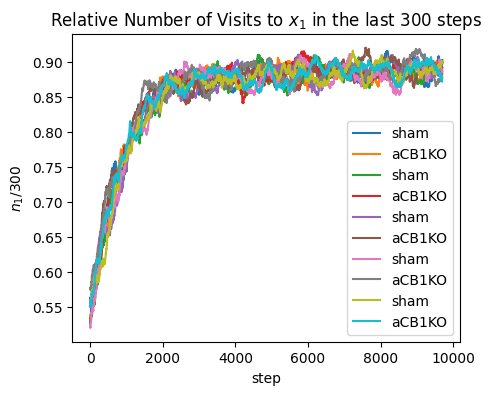

In [26]:
fig, ax = plt.subplots(figsize=(5,4))

for data in starting_points_data:
    window = 300

    all_visits_x1_sham = []
    all_visits_x1_aCB1KO = []

    for agent_id in range(number_of_mice):

        one_hot_vec_x1_sham = np.array([x[0] for x in data['sham'][agent_id]['states']])
        one_hot_vec_x1_aCB1KO = np.array([x[0] for x in data['aCB1KO'][agent_id]['states']])

        visits_x1_sham = []
        visits_x1_aCB1KO = []

        for i in range(steps_phase1-window):
            visits_x1_sham.append(one_hot_vec_x1_sham[i:i+window].mean())
            visits_x1_aCB1KO.append(one_hot_vec_x1_aCB1KO[i:i+window].mean())
        
        all_visits_x1_sham.append(visits_x1_sham)
        all_visits_x1_aCB1KO.append(visits_x1_aCB1KO)

    average_visits_x1_sham = np.mean(all_visits_x1_sham, axis=0)
    average_visits_x1_aCB1KO = np.mean(all_visits_x1_aCB1KO, axis=0)
        
    ax.plot(average_visits_x1_sham, label='sham')
    ax.plot(average_visits_x1_aCB1KO, label='aCB1KO')

ax.set_title("Relative Number of Visits to $x_1$ in the last 300 steps")
ax.set_xlabel('step')
ax.set_ylabel('$n_1$/300')
ax.legend()

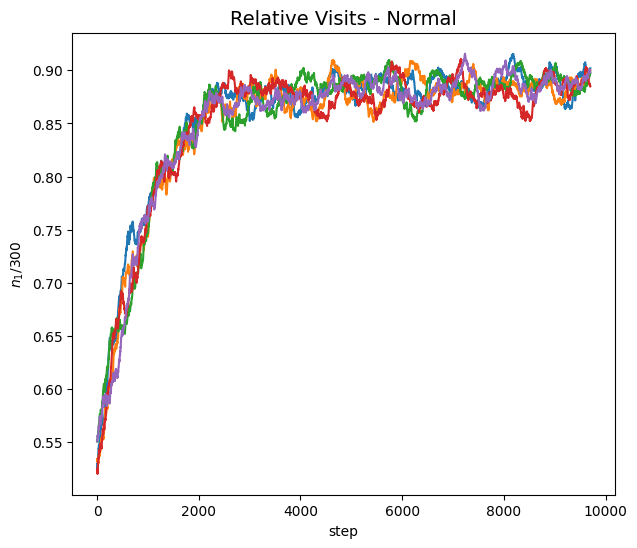

In [31]:
fig, ax = plt.subplots(figsize=(7,6))

for data in starting_points_data:
    
    window = 300
    all_visits_x1_sham = []

    for agent_id in range(number_of_mice):

        one_hot_vec_x1_sham = np.array([x[0] for x in data['sham'][agent_id]['states']])

        visits_x1_sham = []

        for i in range(steps_phase1-window):
            visits_x1_sham.append(one_hot_vec_x1_sham[i:i+window].mean())
        
        all_visits_x1_sham.append(visits_x1_sham)

    average_visits_x1_sham = np.mean(all_visits_x1_sham, axis=0)
        
    ax.plot(average_visits_x1_sham, label='sham')

ax.set_title("Relative Visits - Normal", fontsize=14)
ax.set_xlabel('step')
ax.set_ylabel('$n_1$/300')

fig.savefig('1b.pdf')

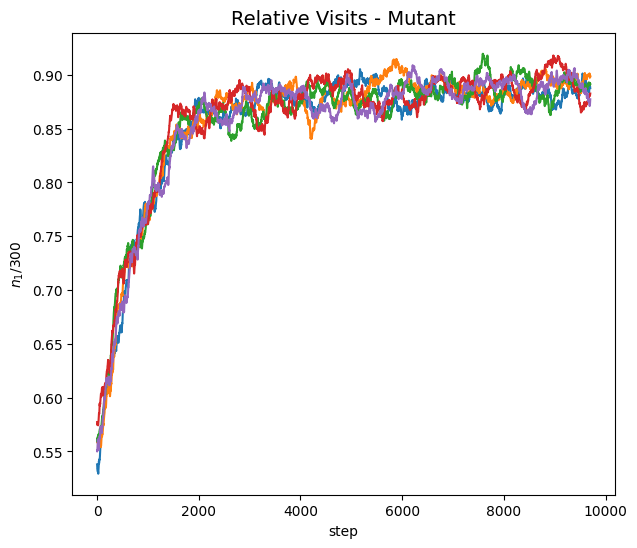

In [30]:
fig, ax = plt.subplots(figsize=(7,6))

for data in starting_points_data:
    window = 300
    all_visits_x1_aCB1KO = []

    for agent_id in range(number_of_mice):

        one_hot_vec_x1_aCB1KO = np.array([x[0] for x in data['aCB1KO'][agent_id]['states']])

        visits_x1_aCB1KO = []

        for i in range(steps_phase1-window):
            visits_x1_aCB1KO.append(one_hot_vec_x1_aCB1KO[i:i+window].mean())
        
        all_visits_x1_aCB1KO.append(visits_x1_aCB1KO)

    average_visits_x1_aCB1KO = np.mean(all_visits_x1_aCB1KO, axis=0)
        
    ax.plot(average_visits_x1_aCB1KO, label='aCB1KO')

ax.set_title("Relative Visits - Mutant", fontsize=14)
ax.set_xlabel('step')
ax.set_ylabel('$n_1$/300')

fig.savefig('2b.pdf')